In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rdm

# Lets do some data exploration

In [2]:

types_train = {'Id': np.int32,
               'Store': np.int32,
               'DayOfWeek': np.int32,
               'Date': str,
               'Sales': np.int32,
               'Customers': np.int32,
               'Open': bool,
               'Promo': bool,
               'StateHoliday': str,
               'SchoolHoliday': bool}

df_train = pd.read_csv('./data/train.csv', dtype=types_train, parse_dates=['Date'])
df_train.dtypes

Store                     int32
DayOfWeek                 int32
Date             datetime64[ns]
Sales                     int32
Customers                 int32
Open                       bool
Promo                      bool
StateHoliday             object
SchoolHoliday              bool
dtype: object

Okay, we read the data correctly. Now lets get a feeling for the variables

In [12]:
df_train['Sales'].describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

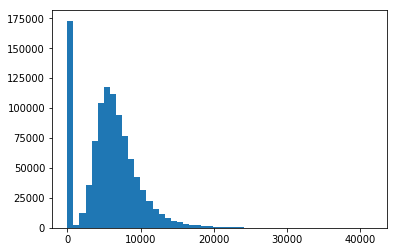

In [41]:
plt.hist(x=df_train['Sales'], bins=50);

Mean and deviation are affected by the days with 0 sales, but these are probably going to be predicted easily using the "Open" feature

In [6]:
df_clean_sales = df_train[df_train['Sales'] > 0]
df_clean_sales['Sales'].describe()

count    844338.000000
mean       6955.959134
std        3103.815515
min          46.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64

In [3]:
entries_per_store = df_train.groupby('Store').size()
print(entries_per_store.to_frame(name='Entries per store').describe())

       Entries per store
count        1115.000000
mean          912.295067
std            67.729422
min           758.000000
25%           942.000000
50%           942.000000
75%           942.000000
max           942.000000


There are indeed 1115 different stores, as descripted in the kaggle challenge. Normally there are 942 datapoints (=days) per store, some have a bit less but at least 758.

Lets do some sanity checks. This helps to see if we understand the data correctly or find errors in the data (unlikly for a kaggle challenge though)

In [4]:
print("Missing values? " + str(df_train.isnull().values.any()))
print('Percentage of days with 0 sales: {0:0.2f}'.format((df_train['Sales'] == 0).sum() / len(df_train['Sales'])))

Missing values? False
Percentage of days with 0 sales: 0.17


Seems reasonable, as 14% of the days are Sundays

In [32]:
print("Entries with 0 sales: " + 
      str((df_train['Sales'] == 0).sum()))
print("Entries with 0 sales and shop is closed: " + 
      str(len(df_train[(df_train['Sales'] == 0) & (~(df_train['Open']))])))
print("Entries with 0 sales although shop is open: " + 
      str(len(df_train[(df_train['Sales'] == 0) & (df_train['Open'])])))
print("Entries with sales > 0 although shop is closed: " + 
      str(len(df_train[(df_train['Sales'] > 0) & (~df_train['Open'])])))

Entries with 0 sales: 172871
Entries with 0 sales and shop is closed: 172817
Entries with 0 sales although shop is open: 54
Entries with sales > 0 although shop is closed: 0


No sales for an open shop seems odd, but 54 out of over 172817 isn't that much. Even if these points are errornous, they wont have a big impact.

In [11]:
print("Entries with store is open on a state holiday: " + 
      str(len(df_train[(df_train['StateHoliday'] != '0') & (df_train['Open'])])))
print("Entries with store is closed on a state holiday: " + 
      str(len(df_train[(df_train['StateHoliday'] != '0') & (~(df_train['Open']))])))

Entries with store is open on a state holiday: 910
Entries with store is closed on a state holiday: 30140


Now lets get a feeling for the other variables, and how big their impact on the sales are. Lets have a look at the correlation matrix

In [15]:
corr = df_train.corr(method='pearson')
corr.round(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.00,-0.00,0.01,0.02,-0.00,0.00,0.00
DayOfWeek,-0.00,1.00,-0.46,-0.39,-0.53,-0.39,-0.21
Sales,0.01,-0.46,1.00,0.89,0.68,0.45,0.09
Customers,0.02,-0.39,0.89,1.00,0.62,0.32,0.07
Open,-0.00,-0.53,0.68,0.62,1.00,0.30,0.09
Promo,0.00,-0.39,0.45,0.32,0.30,1.00,0.07
SchoolHoliday,0.00,-0.21,0.09,0.07,0.09,0.07,1.00


count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64


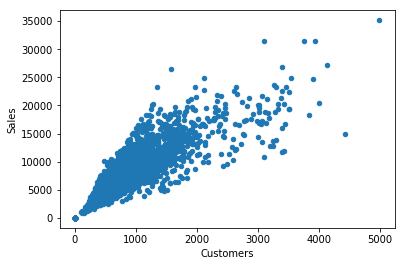

In [12]:
print(df_train['Customers'].describe())
subs_idx = rdm.sample(range(len(df_train)), 8000)
df_subset = pd.concat([df_train['Sales'], df_train['Customers']], axis=1).iloc[subs_idx]
df_subset.plot.scatter(x='Customers', y='Sales')

As expected, we can see a linear relationship between the amount of customers and the sales of a shop. With a correlation of nearly 90% to the target variable, this feature will help a lot to predict the sales.

In [58]:
df_daygrouped = df_train.groupby(['DayOfWeek']).sum()[['Sales', 'Open']]
df_daygrouped['Average Sale per Day'] = df_daygrouped['Sales']/df_daygrouped['Open']
df_daygrouped.round(2)

,Sales,Open,Average Sale per Day
DayOfWeek,,,
1,1130203012,137560.0,8216.07
2,1020411930,143961.0,7088.11
3,954962863,141936.0,6728.12
4,911177709,134644.0,6767.31
5,980555941,138640.0,7072.68
6,846317735,144058.0,5874.84
7,29551433,3593.0,8224.72


Opening on Sundays seems to pay off. No big difference between Tue, We, Thu, Fr